## Финальное соревнование

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

В данном задании вас ждет неизвестная зависимость. Ваша основная задача: **построить две лучших модели**, минимизирующих среднеквадратичную ошибку (MSE):
1. На первую модель не налагается ограничений.
2. Вторая модель должна быть **линейной**, т.е. представлять собой линейную комбинацию признаков плюс свободный член: $\boldsymbol{w}^{\top}\boldsymbol{x} + b$. При этом __вы можете использовать базовые математические операции для преобразования признаков__: np.exp, np.log, np.pow (полный список доступен в [документации](https://numpy.org/doc/stable/reference/routines.math.html)), а также линейные операции над ними (сумма, умножение на число и пр.). Для преобразования признаков вам будет необходимо написать функцию `my_transformation`. __Кол-во параметров (весов) используемых второй моделью не должно превышать 15 (включая свободный член).__

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в будущем писать код более уверенно

In [114]:
import os
import json

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [115]:
import pandas as pd

from sklearn.linear_model import LinearRegression
# Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import phik
from phik import report
from phik.report import plot_correlation_matrix
import seaborn as sns


In [116]:
# Фиксируем RandomState
RANDOM_STATE = 42
RANDOM_VAL = np.random.RandomState(42)

Загрузка данных происходит ниже. Если она не срабатывает, самостоятельно скачайте файл `hw_final_open_data.npy` и положите его в ту же директорию, что и ноутбук.

In [117]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_data.npy -O hw_final_open_data.npy
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_target.npy -O hw_final_open_data.npy

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [118]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

Разбивка на `train` и `val` опциональна и сделана для вашего удобства.

In [119]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)

In [120]:
# train = np.column_stack((train_x, train_y))  # Используя np.column_stack()

# Преобразование в Pandas DataFrame
train = pd.DataFrame(np.column_stack((train_x, train_y)))

In [121]:
feature_columns = [f"{i}" for i in range(train_x.shape[1])]
column_names = feature_columns + ['target']  # Список имен столбцов
train.columns = column_names

# Переименование столбца с целевой переменной в 'target'
train = train.rename(columns={'target': 'target_reg'})  # Замените 'target_column_name' на ваше желаемое имя столбца

In [122]:
# Функция оценки пропусков в таблице
def pass_value_barh(data):
    try:
        missing_data = (data.isna().mean() * 100).to_frame().rename(columns={0: 'space'}).query('space > 0')
        if not missing_data.empty:  # Проверка на наличие пропусков
            missing_data.sort_values(by='space', ascending=True).plot(kind='barh', figsize=(20, 10), 
                                                                      legend=False, fontsize=10)
            plt.title('Пропущенные значения, %' + "\n", fontsize=22)
            print('Всего значений в таблице {0}, из них пропущено от {1} до {2} значений, доля пропущенных '
                  'равна от {3:.2%} до {4:.2%} в {5} столбцах.'.format(len(data),
                                                                   min(i for i in data.isna().sum() if i > 0),
                                                                   max(data.isna().sum()),
                                                                   min(i for i in data.isna().sum() if i > 0) / len(data),
                                                                   max(data.isna().sum()) / len(data),
                                                                   (data.isna().sum(axis=0) > 0).sum()
                                                                   ))
        else:
            print('пропусков не нашлось :) ')
    except Exception as e:
        print('Ошибка при обработке данных:', str(e))

In [123]:
def plot_info_on_numerical_column(df1, df2, feature_title, name):
    # Функция для построения графика гистограммы с статистикой
    def plot_histogram_with_statistics(data, title, label, color, line_color):
        sns.histplot(data=data, x=feature_title, color=color, bins=50, kde=True, label=label, ax=ax, alpha=0.5)
        mean_value = data[feature_title].mean()
        median_value = data[feature_title].median()
        ax.axvline(x=mean_value, color=line_color, lw=2, ls=':', 
                   label=f"{label} mean: {mean_value:.2f}")
        ax.axvline(x=median_value, color=line_color, lw=2, ls='-.', 
                   label=f"{label} median: {median_value:.2f}")

    # Создаем фигуру с одним подграфиком
    fig, ax = plt.subplots(figsize=(10, 8))

    if feature_title in df1.columns:
        plot_histogram_with_statistics(df1, name, "train", "#ef233c", "#2b2d42")
    else:
        ax.text(0.5, 0.5, f"Столбец '{feature_title}' отсутствует в {name[0]}", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)

    if feature_title in df2.columns:
        plot_histogram_with_statistics(df2, name, "test", "#457b9d", "#e63946")
    else:
        ax.text(0.5, 0.4, f"Столбец '{feature_title}' отсутствует в {name[1]}", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)

    ax.set_title(name[2])
    ax.legend(fontsize=10, title_fontsize=10, loc='upper right')

    plt.tight_layout()

# Функция для построения графиков для списка признаков
def plot_df_features_info(df1, df2, name):
    print('')
    print(name)
    print('')

    for column in df1.describe().columns:
        plot_info_on_numerical_column(df1, df2, column, ["train", "test", name])

In [124]:
# Функция изучения данных в таблице
def research_info(data, name):
    rows_count, columns_count = data.shape
    print('Данные {}'.format(name))
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    data.info()
    display(data.sample(n=5))
    display(data.describe())
    pass_value_barh(data)

In [125]:
research_info(train, 'о тренировочном наборе')

Данные о тренировочном наборе
Количество стобцов: 8
Количество строк: 560
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   0           560 non-null    float64
 1   1           560 non-null    float64
 2   2           560 non-null    float64
 3   3           560 non-null    float64
 4   4           560 non-null    float64
 5   5           560 non-null    float64
 6   6           560 non-null    float64
 7   target_reg  560 non-null    float64
dtypes: float64(8)
memory usage: 35.1 KB


,0,1,2,3,4,5,6,target_reg
429,-0.560162,1.074575,-0.56863,0.379307,-0.479721,3.450427,-0.575438,7.336945
241,-0.563300,-0.137595,-0.56863,-0.183105,-0.509765,0.583120,-0.575438,2.334507
540,-0.561548,0.348070,-0.56863,0.067785,-0.494326,1.755891,-0.575438,4.329986
156,-0.561035,0.570104,-0.56863,0.168659,-0.489200,2.279394,-0.575438,4.842217
491,-0.562143,0.142360,-0.56863,-0.032128,-0.499919,1.264792,-0.575438,2.963908


,0,1,2,3,4,5,6,target_reg
count,560.000000,560.000000,5.600000e+02,560.000000,560.000000,560.000000,5.600000e+02,560.000000
mean,-0.562412,0.258271,-5.686305e-01,-0.000727,-0.500573,1.519405,-5.754376e-01,3.704544
std,0.001941,0.515823,1.444095e-12,0.258000,0.016205,1.235348,1.926933e-11,2.197919
min,-0.567454,-0.507269,-5.686305e-01,-0.448910,-0.536785,-0.367869,-5.754376e-01,-0.607470
25%,-0.563718,-0.209950,-5.686305e-01,-0.226384,-0.513030,0.403373,-5.754376e-01,1.774909
50%,-0.561954,0.202505,-5.686305e-01,-0.002149,-0.498178,1.409081,-5.754376e-01,3.633106
75%,-0.560820,0.678503,-5.686305e-01,0.215839,-0.486949,2.532959,-5.754376e-01,5.467735
max,-0.559918,1.250293,-5.686305e-01,0.448173,-0.476899,3.853662,-5.754376e-01,8.013126


пропусков не нашлось :) 


interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', 'target_reg']


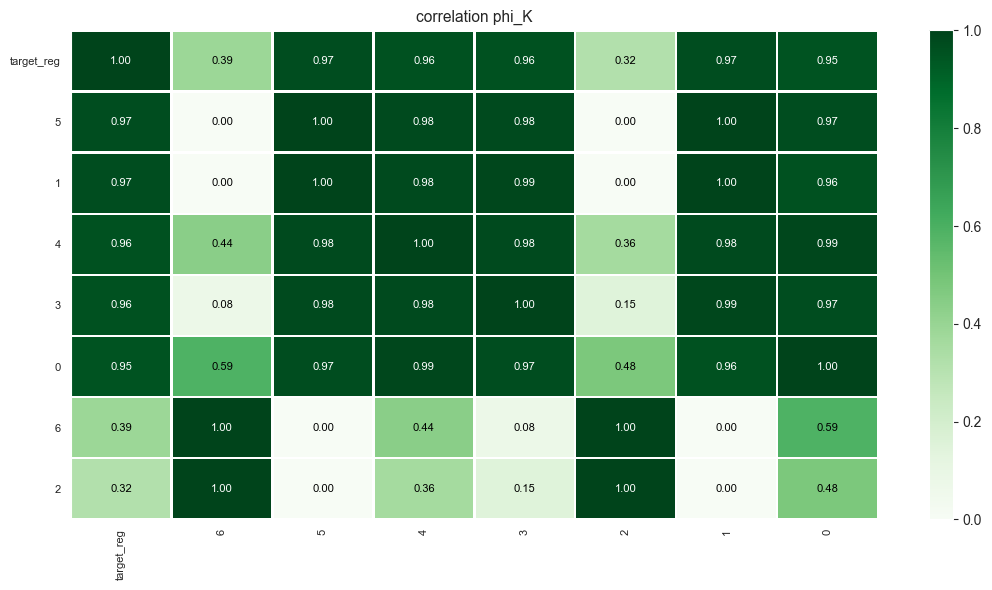

In [126]:
phik_overview = train.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation phi_K", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [127]:
phik_overview

,0,1,2,3,4,5,6,target_reg
2,0.48,0.00,1.00,0.15,0.36,0.00,1.00,0.32
6,0.59,0.00,1.00,0.08,0.44,0.00,1.00,0.39
0,1.00,0.96,0.48,0.97,0.99,0.97,0.59,0.95
3,0.97,0.99,0.15,1.00,0.98,0.98,0.08,0.96
4,0.99,0.98,0.36,0.98,1.00,0.98,0.44,0.96
1,0.96,1.00,0.00,0.99,0.98,1.00,0.00,0.97
5,0.97,1.00,0.00,0.98,0.98,1.00,0.00,0.97
target_reg,0.95,0.97,0.32,0.96,0.96,0.97,0.39,1.00


### Модель №1
Напоминаем, в первой части задания ваша основная задача – получить наилучший результат без ограничений на модель. Сдаваться будут только предсказания модели.

Пример с использованием Random Forest доступен ниже.

In [128]:
def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1] + 1))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    new_feature_matrix[:, -1] = feature_matrix[:, 0] * feature_matrix[:, 1]
    return new_feature_matrix


transformed_train_x = my_transformation(train_x)

In [129]:
# rf = RandomForestRegressor()
# rf.fit(train_x, train_y)

# lr = LinearRegression()
lr = Ridge()
lr.fit(transformed_train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(lr.predict(transformed_train_x), train_y):.5f}',
    f'validation mse = {mean_squared_error(lr.predict(my_transformation(valid_x)), valid_y):.5f}',
    sep='\n'
)

# print(
#     f'train mse =\t {mean_squared_error(np.round(rf.predict(train_x), 2), np.round(train_y)):.5f}',
#     f'validation mse = {mean_squared_error(np.round(rf.predict(valid_x)), np.round(valid_y)):.5f}',
#     sep='\n'
# )

train mse =	 0.09280
validation mse = 0.08500


##### Сдача первой части соревнования
Загрузите файл `hw_final_closed_data.npy` (ссылка есть на странице с заданием). Если вы используете sklearn-совместимую модель, для генерации посылки вы можете воспользоваться функцией `get_predictions`. В ином случае перепишите функцию для вашей модели и запустите код под следующей ячейкой для генерации посылки.

In [130]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy -O hw_final_closed_data.npy

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [131]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

Если необходимо, преобразуйте данные. Преобразованную матрицу объект-признак сохраните в переменную `closed_data`.

In [132]:
# optional transformations

In [133]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

Обращаем ваше внимание, предсказания округляются до сотых!

In [134]:
predicted_values = np.round(get_predictions(model=lr, eval_data=my_transformation(closed_data)), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

In [135]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.npy`')
# __________end of block__________

File saved to `submission_dict_final_p01.npy`


### Модель №2
Функция `my_transformation` принимает на вход матрицу объект-признак (`numpy.ndarray` типа `np.float`) и преобразует ее в новую матрицу. Данная функция может использовать только numpy-операции, а также арифметические действия.

Для примера доступна функция ниже. Она лишь добавляет новый признак, представляющий собой произведение первого и второго исходных признаков (считая с нуля).

In [136]:
def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    new_feature_matrix[:, -1] = feature_matrix[:, 0] * feature_matrix[:, 1]
    return new_feature_matrix

In [137]:
# # Функция преобразования признаков
# def my_transformation(feature_matrix):
#     transformed_features = np.zeros((feature_matrix.shape[0], 5))
# 
#     # Пример преобразования: вычисление логарифма, экспоненты и квадрата признаков
#     transformed_features[:, 0] = np.log(np.abs(feature_matrix[:, 0]) + 1e-5)
#     transformed_features[:, 1] = np.exp(feature_matrix[:, 1])
#     transformed_features[:, 2] = np.square(feature_matrix[:, 2])
#     transformed_features[:, 3] = np.power(feature_matrix[:, 3], 3)
#     transformed_features[:, 4] = feature_matrix[:, 4] * feature_matrix[:, 5]
# 
#     return transformed_features

In [138]:
transformed_train_x = my_transformation(train_x)

In [139]:
lr = Ridge()
lr.fit(transformed_train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(lr.predict(transformed_train_x), train_y):.5f}',
    f'validation mse = {mean_squared_error(lr.predict(my_transformation(valid_x)), valid_y):.5f}',
    sep='\n'
)

train mse =	 0.09280
validation mse = 0.08500


Обращаем ваше внимание, что параметры линейной модели будут округляться до __четырех знаков после запятой__. Это не должно сильно повлиять на качество предсказаний:

In [140]:
original_predictions = lr.predict(transformed_train_x)
rounded_predictions = transformed_train_x.dot(np.round(lr.coef_, 4)) + np.round(lr.intercept_, 4)


assert np.allclose(original_predictions, rounded_predictions, atol=1e-3)

Параметры вашей модели:

In [141]:
w_list = list(np.round(lr.coef_, 4))
print(f'w = {list(np.round(lr.coef_, 4))}\nb = {np.round(lr.intercept_, 4)}')

w = [0.0141, 0.4274, 0.0, 0.6438, 0.0873, 1.3872, 0.0, -0.2536]
b = 1.502


Напоминаем, ваша модель не должна использовать более 15 параметров (14 весов плюс свободный член).

In [142]:
assert len(w_list) + 1 <= 15

##### Сдача второй части соревнования
Для сдачи вам достаточно отправить функцию `my_transformation` и параметры вашей модели в контест в задачу №2. Пример посылки доступен ниже. Имортирование `numpy` также необходимо.

In [143]:
# __________example_submission_start__________
import numpy as np
def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    new_feature_matrix[:, -1] = feature_matrix[:, 0
    ] * feature_matrix[:, 1]
    return new_feature_matrix

w_submission = [0.0119, 0.4478, 0.0, 0.5941, 0.0755, 1.3903, 0.0, -0.2631]
b_submission = 1.496
# __________example_submission_end__________

На этом задание завершено. Поздравляем!